# *** PROJECT - 영화 리뷰 감성 분석 (BERT를 활용한 문장 분류)***

# BERT
- 아주 거대한 데이터셋을 이용해 pre-train된 모델
- 처음부터 학습을 시키는 것 (training from scratch)에 들어가는 시간, 에너지, 지식, 그리고 자원을 아낄 수 있음
- Transformer 형식을 차용하지만 Encoder layer block만 사용한 (pre-trained)language model.
```
# Encoder Layers
BASE모델 : 12개 // LARGE모델 : 24개
# Feedforward-network(hidden)
BASE모델 : 768개 // LARGE모델 : 1024개
# Attention heads
BASE모델 : 12개 // LARGE모델 : 16개
```
- 프로젝트에서 사용할 모델(한국어 데이터)
```
# Multilingual Cased 
12-layer, 768-hidden, 12-heads
```



# 학습된 언어모델 전이학습(Transfer Learning)
- fine tuning : 학습된 언어 모델을 이용하여 실제 자연어처리 Task를 푸는 과정
> TASK
<br> - 한 문장 입력 
<br> - 두 문장 입력
- 기존 알고리즘들은 자연어의 다양한 Task에 따라 각각의 알고리즘을 독립적으로 만들어야 했지만, BERT 개발로 인해 자연어처리 연구자들은 언어 모델을 만드는데 더 공을 들이게 됨
- 전이학습은 라벨이 주어지므로 지도학습(Supervised Learning)
> BERT 언어 모델은 Semi-Supervised Learning(MASK처리된 값을 레이블로 치고, 알아서 학습)
- 전이학습은 BERT 언어 모델의 출력에 추가적인 모델을 쌓아서 사용
- 일반적으로, 복잡한 CNN, LSTM, Attention을 쌓지 않고 간단한 DNN만 쌓아도 성능이 잘 나오며 별 차이가 없다고 알려짐

# 가설


```
다음 조건들에 의해서도
1) BERT 전이학습 활용
2) 분류를 위한 Dense layer 한개의 층
3) 적은량의 데이터
4) 작은 EPOCHS
분류 정확도가 80% 이상 나올 것이다.
```



# 주요 포인트 2가지
- BertTokenizer - Wordpiece 방식
- Input vector 형식

# 라이브러리

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 37.2 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
     |████████████████████████████████| 895 kB 35.7 MB/s 
     |████████████████████████████████| 596 kB 32.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
! pip install konlpy
# 파이썬에 없고, 리눅스 상에서 돌아가는 S/W를 다운로드 받는 명령어 : apt
! apt-get update
# ! apt-get upgrade # 이거 오래걸림 
! apt install curl
! apt install git

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 11.6 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x8

In [ ]:
# Mecab 설치
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Installing automake (A dependency for mecab-ko)
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.

In [ ]:
import os
import re
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import transformers
from konlpy.tag import Mecab 

from tqdm import tqdm #시간표시
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 데이터 로드

In [ ]:
tf.random.set_seed(111)
np.random.seed(111)

In [ ]:
import urllib.request

train_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
test_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt")

# pandas table 형태로 저장
train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

# EDA

In [ ]:
# 결측값 확인
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id          0
document    5
label       0
dtype: int64
id          0
document    3
label       0
dtype: int64


In [ ]:
# 결측값 제거
train_data = train_data.dropna()
test_data = test_data.dropna()

In [ ]:
train_data.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [ ]:
test_data.head(3)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0


In [ ]:
# label 분포확인
print(train_data['label'].value_counts(normalize=True))
print(test_data['label'].value_counts(normalize=True))

0    0.50115
1    0.49885
Name: label, dtype: float64
1    0.50345
0    0.49655
Name: label, dtype: float64


In [ ]:
len(train_data), len(test_data)

(149995, 49997)

In [ ]:
# 데이터 축소 : 학습시간 너무 오래걸림..

def dataframe_sort_values(df):
    df = df.sort_values(by=['label'], ascending=[True])
    return df.reset_index(drop=True)

In [ ]:
train_data = dataframe_sort_values(train_data)
test_data = dataframe_sort_values(test_data)

In [ ]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,485929,눈아프고 짜증난다. 영화의 의도는 대체 몬지;;,0
2,10000339,천재인척. 예술적인척. ㅎ,0
3,6831503,장르 코미디는 아닌것같고..그냥 드라마다.. 코믹요소 생각하고 보는거면 대실망 할꺼다..,0
4,869983,진짜 재미없다,0
...,...,...,...
149990,10262164,애들 데리고 간만에 영화 보러 왔는데재밌네요. 스토리도 탄탄하고만화인데도 스케일이 ...,1
149991,9817829,FIN 이 뜨는순간 너무나도 가슴아팠다...어린아이들의 순수함,1
149992,6618808,지민누나최고다지환이형도,1
149993,10123505,1 2 3 편중 가장 아쉬운 2편...,1


In [ ]:
# train: 75,000 rows // test 25,000 rows

train_label_0 = train_data.iloc[:37500] # label 0인 행 37500개 
train_label_1 = train_data.tail(n=37500) # label 1인 행 37500개 
train_data = pd.concat([train_label_0, train_label_1]) # Concat => 총 75000 행
print(f'train_data의 총 행 개수는: {len(train_data)}')

test_label_0 = test_data.iloc[:12500] # label 0인 행 12500개 
test_label_1 = test_data.tail(n=12500) # label 1인 행 12500개 
test_data = pd.concat([test_label_0, test_label_1]) # Concat => 총 25000 행
print(f'test_data의 총 행 개수는: {len(test_data)}')

train_data의 총 행 개수는: 75000
test_data의 총 행 개수는: 25000


In [ ]:
# Shuffling and reset_index
train_data = train_data.sample(frac=1)\
                       .reset_index(drop=True)
test_data = test_data.sample(frac=1)\
                       .reset_index(drop=True)

# 전처리

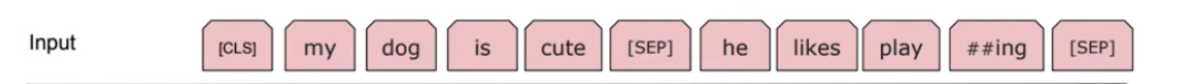

In [ ]:
# [CLS], [SEP] 토큰 붙여야 하지만, 이후 BERT tokenizer의 encode_plus 메서드를 통해 지정해줄 예정
#sentences = ["[CLS] " + str(s) + " [SEP]" for s in train_data[document]]

In [ ]:
train_data['document']

0                      진짜 재밌어요 !! 몰입도 좋고 흥미진진~ 평점이 너무 낮은듯.
1         세 명품배우,몰입도 최고의 현출,간결하고 시같은 대사,상처받은 사람들의 아름다운 치유!
2             시간순서를 뒤바꾸고, 환상을 집어넣고, 기억을 왜곡시켜봐도 결국은 뻔한 치정살인
3             기업과 노조이익을 위한 임금삭감노조탄압을 위한 조폭투입그런면에서 보면 명작...
4                         진부한 신데렐라 영화... 평점이 높은게 도저히 이해가..
                               ...                        
74995                                         이게 코미디라니..ㅎㅎ
74996    겨울마다 찾게 만드는 영화..어쩐지 마음이 좀 추워질 즈음이면.. 보고파지는 영화....
74997                          음... 너무 지루하게 봤습니다..... 아쉽네요
74998             totally brainless stupid-ass ballbuster!
74999                        로맨스이긴 하지만, 내용의 흐림이 어딘가모르게 어색함
Name: document, Length: 75000, dtype: object

In [ ]:
# Regex
import re

after_regex = []

for sent in train_data['document']:
    regex = re.sub('[^가-힣]',' ', sent)
    after_regex.append(regex)

after_regex

['진짜 재밌어요    몰입도 좋고 흥미진진  평점이 너무 낮은듯 ',
 '세 명품배우 몰입도 최고의 현출 간결하고 시같은 대사 상처받은 사람들의 아름다운 치유 ',
 '시간순서를 뒤바꾸고  환상을 집어넣고  기억을 왜곡시켜봐도 결국은 뻔한 치정살인',
 '기업과 노조이익을 위한 임금삭감노조탄압을 위한 조폭투입그런면에서 보면 명작   ',
 '진부한 신데렐라 영화    평점이 높은게 도저히 이해가  ',
 '웃기는건 하나도없고   그냥 다큐보는줄   ',
 '언제 끝나나 기다리다 끝난 영화',
 ' 급 영화에 스토리도 참     밑에   로 개봉했다는게 욕먹을 짓이다 ',
 '개같은영화   자  자',
 '  ',
 '진짜 별그대없엇다면 수목드라마  위노릴만큼 스토리탄탄하고 주연조연탄탄해요  마니아층생기기딱좋은 드라마 정말 이제 마지막회라니   첫회부터 지금까지 긴장을 한순간도 놓지못하게 만드는 반전에 반전드라마 제마음의 최고  오늘 비비화장품 팔리는거 진심행복햇',
 '아 저도 비슷한 경험을 한적있네요  ',
 '우와    졸린다   ',
 '뻔한스토리  시간만 낭비했다 ',
 '한마디로 표현하자면     흐  함         안스럽게도 하품만 무섭게 나오고 있다   ',
 '타에  전형적인 답답이 민폐여주캐릭터 정말 짜증났다  형사는 필요 없었다  성인은 몹이었을뿐  간츠는 완벽한 대답대신 완벽한 의문과 찝찝함을 목격하게했다 그리고 얼굴이 안보일정도로 어둡다   소재독특한거하나로 점수드림',
 '개짜증     ',
 '소재부터 오글 거렸는데     대사도 맘만치 않게 닭살 돋네',
 '재난영화의 대표작',
 '수면제가 필요없다  알람기능하는 전화벨소리까지   ',
 '지금 보고있는데 너무너무 졸리네요   아이도 지루해하고   평점 뻥튀기 심각함   수준이하',
 '한국영화를 살릴려고 영화관에서 영화본 내가 바보였지 ',
 '재미 없음  감동 없음  내용 없음  개연성 없음  시간 존나게 아까움  돈도 아까움  별점도 아까움  킬링타임용으로도 아까움  이걸

In [ ]:
train_data['document'] = after_regex
train_data.head(3)

,id,document,label
0,6119463,진짜 재밌어요 몰입도 좋고 흥미진진 평점이 너무 낮은듯,1
1,9394822,세 명품배우 몰입도 최고의 현출 간결하고 시같은 대사 상처받은 사람들의 아름다운 치유,1
2,5630588,시간순서를 뒤바꾸고 환상을 집어넣고 기억을 왜곡시켜봐도 결국은 뻔한 치정살인,0


In [ ]:
# Regex - test_data
after_regex_test = []

for sent in test_data['document']:
    regex = re.sub('[^가-힣]',' ', sent)
    after_regex_test.append(regex)

after_regex_test

test_data['document'] = after_regex_test
test_data.head(3)

,id,document,label
0,8786134,아따 오 우덜동네에서 일어난 일을 감자바위들한테 뒤집어씌우당가 뭐시여 감독님이...,0
1,3821850,냉혹들 해서 미안하다 흥 영화란 단순히 볼만한 장면으로만 평가할수는 없는거야,0
2,357882,와 영국식코메디는 너무 어려워,0


In [ ]:
""" 이번엔 활용 안함
# Konlpy Mecab 활용 tokenizing
mecab = Mecab()

total_tokens = []

for sent in after_regex:
    sent_token = mecab.morphs(sent)
    total_tokens.append(sent_token)

total_tokens
"""

# BertTokenizer

### [모든 자연어처리 모델]
- 단어 자체의 텍스트 형식이 아닌 토큰화된 상태에서 정수인코딩 및 패딩을 거쳐 입력으로 들어감
- 보통 word 단위 인코딩, character 단위 인코딩을 사용

### [BERT]
- WordPiece 서브워드 토크나이저 사용
- 단어 등장 빈도를 고려하여 단어 집합에 추가하는 점은 다른 토크나이저와 비슷
- 하지만, 낮은 등장 빈도를 가지는 단어는 더 작은 단어인 서브워드로 분리시켜 단어 집합에 추가
<br> (예) ```I am rewriting the posts```
```
# 일반적인 토크나이저
'I', 'am', 'rewriting', 'the', 'posts'
```
```
# WordPiece 토크나이저
'I', 'am', 're', '##writ', '##ing', 'the', 'post', '##s'
==> 단어 집합에 단어가 존재하지 않을 경우, 단어를 더 쪼개려 한다
==> 서브워드로 쪼개진 단어 앞에는 '#'을 표시하여 이 서브워드가 단어의 중간부터 시작된 단어라는 것을 알려준다
==> 이 작업은 BertTokenizer 라이브러리를 사용하여 진행되고, 이렇게 토큰화가 이루어진 상태로 BERT 모델에 입력으로 들어간다
```




In [ ]:
from transformers import BertTokenizer

# BertTokenizer instance
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', #한국어 => 다양한 언어 처리하는 모델로 사용
                                          cashe_dir='bert_ckpt', #checkpoint
                                          do_lower_case=False) #영어 => True

In [ ]:
BATCH_SIZE = 16
NUM_EPOCHS = 2
VALID_SPLIT = 0.2
MAX_LEN = 39 # 토큰 확인 결과 39~40이면 충분

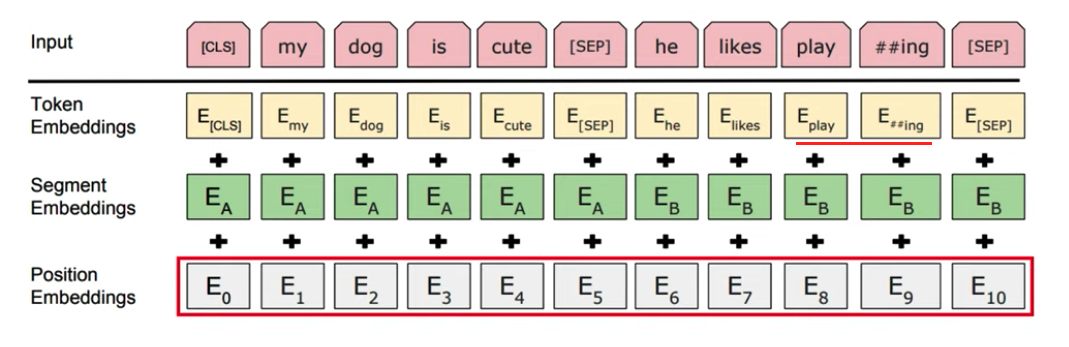

In [ ]:
# BertTokenizer function
def bert_tokenizer(sentence, MAX_LEN):
    encoded_dict = tokenizer.encode_plus( # encode_plus : 문장을 input_ids, attention_masks, token_type_ids를 텐서로 반환
        text = sentence,
        add_special_tokens = True, # [cls], [sep]
        max_length = MAX_LEN, # 토큰 최대 길이 39
        pad_to_max_length = True, # padding : 최댓값으로 (post-padding)
        truncation = True ==> 토큰 길이가 max_length보다 길면 자름
        return_attention_mask = True, # attention mask 생성
        #return_token_type_ids = True # default
    )

    ## encode_plus의 리턴값에 대한 변수 지정
    # Token Embeddings
    input_id = encoded_dict['input_ids'] 
    
    # padding 유무를 알려주는 Embedding => unpadded:1, padded:0
    # 0값을 가지는 패딩 토큰에 대해 어텐션 연산을 불필요하게 수행하지 않도록 단어 토큰과 패딩 토큰을 구분할 수 있게 알려주는 것
    attention_mask = encoded_dict['attention_mask'] 

    """ attention mask는 다음 코드로 설명
    attention_masks = []

    for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
    """

    # Segment Embedding
    token_type_id = encoded_dict['token_type_ids']

    return input_id, attention_mask, token_type_id

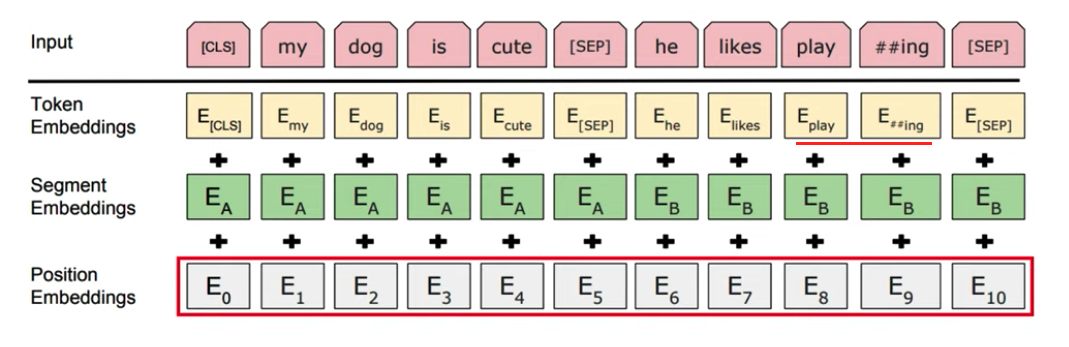

In [ ]:
## 훈련용 데이터 만드는 작업

input_ids = [] # Token Embedding
attention_masks = [] # padding 유무를 알려주는 Embedding(불필요한 어텐션 연산 제거)
token_type_ids = [] # Segment Embedding
train_data_labels = []

for train_sentence, train_label in tqdm(zip(train_data['document'], train_data['label']),
                                        total=len(train_data)): # total : len(train_data)수만큼 반복을 돈다.

  try: #오류가 있을수도 있기 때문에 try - except 활용
    input_id, attention_mask, token_type_id = bert_tokenizer(train_sentence, MAX_LEN) # 위에서 정의한 함수

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    train_data_labels.append(train_label)

  except Exception as e:
    print(e)
    pass

# 리스트 => 텐서형태로 변환
train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_token_type_ids = np.array(token_type_ids, dtype=int)

# packing for input : TFBertModel 인풋 형식(IN ORDER!)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_token_type_ids) 

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #np.asarray(data, dtype=) data의 dtyp이 지정해준 dtype과 다르면 복사한다.

print("Sentences: {}\nLables: {}".format(len(train_movie_input_ids), len(train_data_labels)))

  0%|          | 0/75000 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 75000/75000 [00:30<00:00, 2429.28it/s]


Sentences: 75000
Lables: 75000


In [ ]:
train_data.document[0]

'진짜 재밌어요    몰입도 좋고 흥미진진  평점이 너무 낮은듯 '

In [ ]:
idx = 0
input_id = train_movie_input_ids[idx]
attention_mask = train_movie_attention_masks[idx]
token_type_id = train_movie_token_type_ids[idx]

# 토큰 Embedding
print(input_id) 

# padding 유무를 알려주는 Embedding => unpadded:1, padded:0
print(attention_mask) 

# Segment Embedding 
print(token_type_id)

# decoding
print(tokenizer.decode(input_id))          

[   101   9708 119235    100   9287  58303  12092   9685  11664  10021
  22458  18623  18623   9926  34907  10739   9004  32537   8992  10892
 118817    102      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[CLS] 진짜 [UNK] 몰입도 좋고 흥미진진 평점이 너무 낮은듯 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
"""
GPU 사용 가능한지 확인
import torch
use_cuda = torch.cuda.is_available()
print(use_cuda)
"""

True


### 임베딩 취합
- Position encoding은 단순하게 Token 순서대로 0, 1, 2, ... 순서대로 인코딩
- 3가지 입력 임베딩 취합하여 하나의 임베딩 값으로 생성
- 임베딩 합에 Layer Normalization과 Dropout을 적용하여 입력으로 사용

In [ ]:
from transformers import TFBertModel

class TFBertClassifier(tf.keras.Model): # tf.keras.Model 상속받는다
  def __init__(self, model_name, dir_path, num_class):
    super(TFBertClassifier, self).__init__()

    self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
    self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob) # default = 0.1
    self.classifier = tf.keras.layers.Dense(num_class, # class 수
                                            kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                            name='classifier')
                                            """
                                            <kernel_initializer>
                                            파라미터 초기화 함수의 한 종류 
                                            
                                            <TruncatedNormal>
                                            선택 범위를 평균으로부터 2 표준편차 안쪽으로 제한하여 전체 분포는 +-2 표준편차 바깥이 잘려나간 형태.
                                            
                                            <initializers_range : bert.config(0.02) / TruncatedNormal의 default = 0.05>
                                            The standard deviation of the truncated_normal_initializer for initializing all weight matrices.
                                            """                                          
    
    # kernel_initializer : https://github.com/keras-team/keras-docs-ko/blob/master/sources/initializers.md#truncatednormal
    # BertConfig : https://huggingface.co/transformers/model_doc/bert.html#bertconfig
    
  def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
    
    ## outputs (참고해보세요 : https://colab.research.google.com/drive/17PajmZCbnUfBTSekEfDoqE7C5GkNi5j9#scrollTo=dwVYvjsf0pRy)
    """
    ==> last_hiddien_state : shape = (batch_size, sequence_length, hidden_size)
    ==> pooled_output : shape = (batch_size, hidden_size)
    """
    outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
    pooled_output = outputs[1]
    pooled_output = self.dropout(pooled_output, training=training)
    logits = self.classifier(pooled_output) #classifier: dense레이어. 이곳에 pooled_output을 최종통과 시킨 값 = logits

    return logits #최종 결과

cls_model = TFBertClassifier(model_name = 'bert-base-multilingual-cased',
                             dir_path = 'bert_ckpt',
                             num_class=2)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


#모델 학습

### ***from_logits***
```
tf.keras.losses.BinaryCrossentropy
tf.keras.losses.CategoricalCrossentropy
tf.keras.losses.SparseCategoricalCrossentropy
```
모델의 출력값이 문제에 맞게 normalize 되었느냐의 여부.
- logit=False : 모델이 출력값으로 해당 클래스의 범위에서의 확률을 출력할 때
- logit=True : 모델의 출력값이 sigmoid 또는 linear를 거쳐서 확률이 아닌 값이 출력될 때

```
# Tensorflow github
from_logits = True인 경우, nn.softmax_cross_entropy_with_logits 함수로 바로 넘어간다.
이 함수에서 logits(output)을 인자로 받아 softmax 함수를 거친 후, crossentropy loss를 계산한다.
+ 텐서플로우에서는 softmax 함수를 거치지 않고, from_logits = True를 사용하는게 numerical stable하다고 설명하고 있다.
```
Ref. https://hwiyong.tistory.com/335
<br> Ref. https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy




In [ ]:
## 학습준비

optimizer = tf.keras.optimizers.Adam(3e-5) # epsilon # lr_schedule = tf.keras.optimizers.schedules 나중에 사용해보기
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # label이 one-hot vector가 아닌 정수형태
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model_name = "tf2_bert_naver_movie"

# checkpoint
checkpoint_path = os.path.join('./', model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} Directory already exists\n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} Directory create complete\n".format(checkpoint_dir))

## cp_callback
checkpoint_callback = ModelCheckpoint(checkpoint_path, 
                              monitor='val_accuracy',
                              verbose=1, 
                              save_best_only=True,
                              save_weights_only=True)
## es_callback
"""
min_delta : the threshold that triggers the termination 
patience : no improvment epochs
"""
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

## 인풋 형식 (참고 : https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel)
# train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_token_type_ids)
history = cls_model.fit(train_movie_inputs, train_data_labels,
                        epochs=NUM_EPOCHS,
                        batch_size=BATCH_SIZE, #32, 64, 128
                        validation_split=VALID_SPLIT,
                        callbacks=[earlystop_callback, checkpoint_callback])

./tf2_bert_naver_movie Directory create complete

Epoch 1/2
3750/3750 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.7756
Epoch 00001: val_accuracy improved from -inf to 0.82207, saving model to ./tf2_bert_naver_movie/weights.h5
3750/3750 [==============================] - 1381s 364ms/step - loss: 0.4627 - accuracy: 0.7756 - val_loss: 0.4142 - val_accuracy: 0.8221
Epoch 2/2
3750/3750 [==============================] - ETA: 0s - loss: 0.3576 - accuracy: 0.8396
Epoch 00002: val_accuracy improved from 0.82207 to 0.83640, saving model to ./tf2_bert_naver_movie/weights.h5
3750/3750 [==============================] - 1361s 363ms/step - loss: 0.3576 - accuracy: 0.8396 - val_loss: 0.3889 - val_accuracy: 0.8364


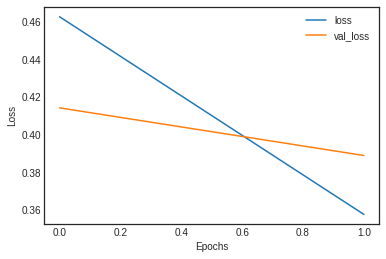

In [ ]:
# Loss 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

# 모델 평가

In [ ]:
## 테스트 데이터 만드는 작업 (위의 '## 훈련용 데이터 만드는 작업' 코드와 동일)

input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sentence, test_label in tqdm(zip(test_data['document'], test_data['label']),
                                        total=len(test_data)): # total : len(test_data)수만큼 반복을 돈다.

  try: #오류가 있을수도 있기에 try - except 활용
    input_id, attention_mask, token_type_id = bert_tokenizer(test_sentence, MAX_LEN)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    test_data_labels.append(test_label)

  except Exception as e:
    print(e)
    pass

test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_token_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_token_type_ids)
test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #np.asarray(data, dtype=) data의 dtyp이 지정해준 dtype과 다르면 복사한다.

print("Sentences: {}\nLables: {}".format(len(test_movie_input_ids), len(test_data_labels)))

  0%|          | 0/25000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 25000/25000 [00:09<00:00, 2558.35it/s]


Sentences: 25000
Lables: 25000


In [ ]:
cls_model.evaluate(test_movie_inputs, test_data_labels, batch_size=512)

49/49 [==============================] - 113s 2s/step - loss: 0.3896 - accuracy: 0.8359


[0.38962966203689575, 0.835919976234436]

In [ ]:
cls_model.summary()

Model: "tf_bert_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_1 (TFBertMode  multiple                 177853440 
 l)                                                              
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 177,854,978
Trainable params: 177,854,978
Non-trainable params: 0
_________________________________________________________________


# Chance Level(0.5)
- 0.8359의 테스트 정확도를 보임으로써 Chance level을 넘김

# 한계점과 추후 해결 방안


```
# 한계점
- 제한된 프로젝트 진행 시간으로, 다양한 데이터셋에 BERT모델을 적용해보지 못했다.
- BERT 외 RNN을 기반으로 한 모델(LSTM, GRU 등)에 동일한 데이터셋을 활용해 성능 비교를 하지 못했다.
```


```
# 추후 액션
- 먼저, 동일한 데이터셋을 활용하여 RNN 기반 모델의 성능을 확인하고, BERT와 비교해본다.
- Konlpy 형태소 분석기를 활용하여 이번 프로젝트에서 이용한 'bert-base-multilingual-cased'과 성능 비교해본다.
```



In [ ]:
#간략한 정리
## Token Embeddings
# word Piece 임베딩 : 모든 언어에 적용 가능 => sub-word 단위로 단어를

## Sentence Embeddings
# BERT : 두 개의 문장을 문장 구분자([SEP])와 함께 결합
# 입력 길이의 제한 : 두 문장 합쳐서 512 subword 이하로 제한
# 입력 길이 길어지면 학습시간은 제곱으로 증가
# 한국어 : 보통 평균 20 subword로 구성, 99%가 60 subword를 넘지 않기 때문에 입력 길이를 두 문장이 합쳐 128로 해도 충분

## Position Embeddings
# Transformer 모델을 차용 : Self-Attention
# Position encoding은 단순하게 Token 순서대로 0, 1, 2, ... 순서대로 인코딩

## 임베딩 취합
# 3가지 입력 임베딩 취합하여 하나의 임베딩 값으로 생성
# 임베딩 합에 Layer Normalization과 Dropout을 적용하여 입력으로 사용

## MLM (Masked language model)
# 입력의 15% 단어를 [MASK] Token으로 바꾸어 마스킹
# 이때 80%는 [MASK], 10%는 다른 랜덤 단어, 나머지 10%는 바꾸지 않고 그대로 유지
# ==> 미세 조정 시 올바른 예측을 돕도록 마스킹에 노이즈를 섞는 것임
# MLM은 [MASK]가 어떤 단어인지를 예측
# BERT의 Token 임베딩은 Word Piece 임베딩 방식을 사용, Word piece의 단어수는 30,522 단어
# 3만 단어 중 [MASK]에 들어갈 단어를 찾는 것이므로 MLM 출력인 Softmax의 클래스는 3만개 (어마어마함)

## NSP (Next Sentence Prediction)
# 두 문장이 주어졌을 때, 두 번째 문장이 첫 번째 문장의 바로 다음에 오는 문장인지 여부를 예측
# 두 문장 간 관련이 고려되어야 하는 NLI와 QA의 파인튜닝을 위해 두 문장이 연관이 있는지를 맞추도록 학습
# 첫 문장과 두번째 문장은 [SEP]로 구분
# 두 문장이 실제로 연속하는지는 => 50% 비율로 참인 문장을 주어주고, 50% 비율로 랜덤하게 추출된 상관 없는 문장으로 구성
# ==> 이 학습을 통해 문맥과 순서를 언어모델이 학습 가능!
# 연속 문장 or 불연속 문장 분류이므로 Softmax의 클래스는 2개 ==> MLM에 비해 학습속도가 빠름